# Text style generation

In [56]:
from styles import styles, styles_count
from copy import deepcopy
import numpy as np


def random_text_style_generator(styles, styles_count):
    styles_probs = {k: [(e+1)/(sum(v)+len(v)) for e in v] for k, v in deepcopy(styles_count).items()}

    assert sum(sum(styles_probs[k]) for k in styles_probs) - len(styles_count) < 1e-6

    while True:
        style = dict()
        prob = 1.0

        for key in styles_probs:
            style_part_idx = np.random.choice(np.arange(len(styles[key])), p=styles_probs[key])
            style[key] = styles[key][style_part_idx]
            prob *= styles_probs[key][style_part_idx]
        
        yield style, prob

style_generator = random_text_style_generator(styles, styles_count)

for i in range(5):
    style, prob = next(style_generator)
    print(f'{style}, prob: {round(prob, 6)}')

{'прическа': 'короткая прямые', 'цвет волос': 'серебристо серый', 'аксесуар': 'солнцезащитные очки', 'одежда': 'комбинезон', 'цвет одежды': 'белый'}, prob: 0.001355
{'прическа': 'длинные прямые', 'цвет волос': 'блонд', 'аксесуар': 'круглые очки', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'синий'}, prob: 0.000875
{'прическа': 'нет волос', 'цвет волос': 'блонд', 'аксесуар': 'солнцезащитные очки', 'одежда': 'футболка с V-вырезом', 'цвет одежды': 'белый'}, prob: 9.3e-05
{'прическа': 'длинные прямые', 'цвет волос': 'рыжий', 'аксесуар': 'солнцезащитные очки', 'одежда': 'худи', 'цвет одежды': 'зеленый'}, prob: 0.000528
{'прическа': 'короткая прямые', 'цвет волос': 'каштановый', 'аксесуар': 'нет очков', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'зеленый'}, prob: 0.000147


# Visual style generation

In [109]:
import cv2
import os
import matplotlib.pyplot as plt


avatars_path = './avatars'
avatars = [cv2.imread(os.path.join(avatars_path, fn)) for fn in os.listdir(avatars_path)]
avatars = [cv2.cvtColor(a, cv2.COLOR_BGR2RGB) for a in avatars]

assert all(a.shape == avatars[0].shape for a in avatars)

a_shape = avatars[0].shape

pixel_probs = np.zeros((a_shape[0], a_shape[1], a_shape[2], 256), dtype=np.float32)

for a in avatars:
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                pixel_probs[i, j, k, a[i, j, k]] += 1

pixel_probs_additive = pixel_probs + 1
pixel_probs_additive /= pixel_probs_additive.sum(axis=3)[..., None]
pixel_probs /= pixel_probs.sum(axis=3)[..., None]

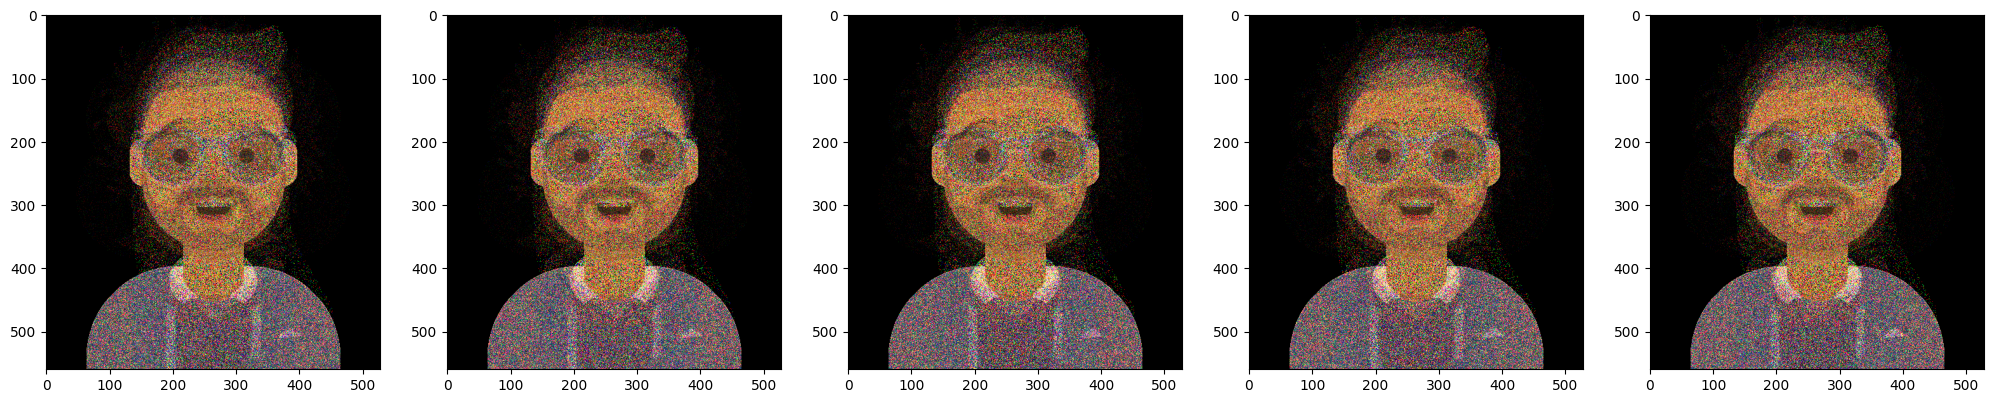

In [113]:
def random_visual_style_generator(pixel_probs):
    cumulative_pixel_probs = np.cumsum(pixel_probs, axis=3) # pdf -> cdf (чтобы хитро сэмплить сразу всю матрицу)

    while True:
        sample = np.random.uniform(size=pixel_probs.shape[:3]) # сэмплим из U(0, 1)

        # для каждого канала каждого пикселя находим хитро выбираем значение 
        sample = np.argmin(np.abs(cumulative_pixel_probs - sample[..., None]), axis=3) 
        
        yield sample.astype('uint8')

gen = random_visual_style_generator(pixel_probs)
fig, axes = plt.subplots(ncols=5, figsize=(25, 5))

for i in range(5):
    sample = next(gen)
    axes[i].imshow(sample)
    cv2.imwrite(f'./generated_avatars/polynomial/{i}.jpg', cv2.cvtColor(sample, cv2.COLOR_RGB2BGR))

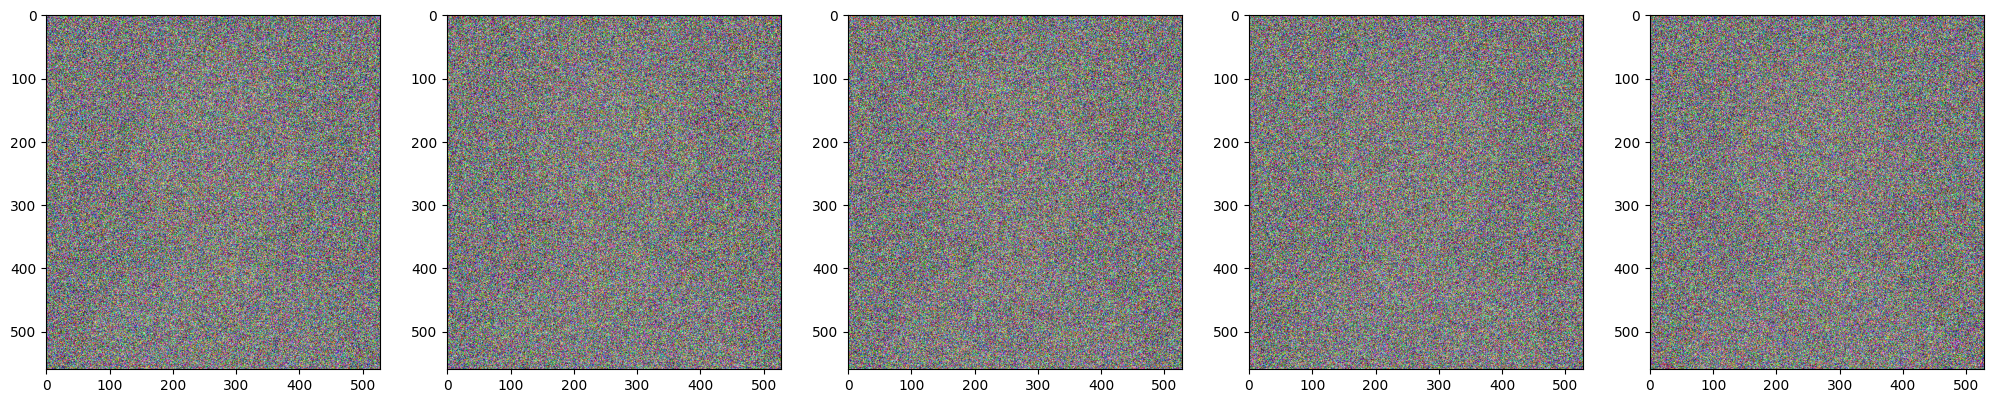

In [114]:
gen = random_visual_style_generator(pixel_probs_additive)
fig, axes = plt.subplots(ncols=5, figsize=(25, 5))

for i in range(5):
    sample = next(gen)
    axes[i].imshow(sample)
    cv2.imwrite(f'./generated_avatars/additive_smoothing/{i}.jpg', cv2.cvtColor(sample, cv2.COLOR_RGB2BGR))

Слишком мало примеров, чтобы получить что-то адекватное из-за использования аддитивного сглаживания. 

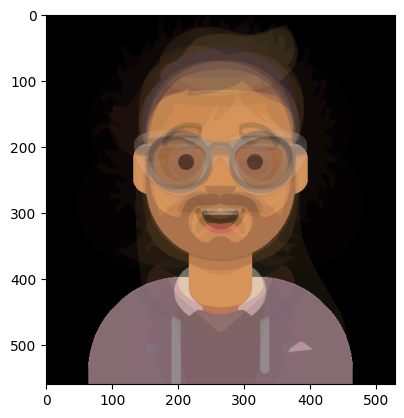

In [78]:
mean_sample = np.stack(avatars, axis=0).mean(axis=0).astype('uint8')
plt.imshow(mean_sample)